# NLP 2021 HW1

Три датасета с твитами: 

- тренировочный
- тестовый
- валидационный

Нужно определить, какие твиты могут упоминать побочный эффекты от лекарств.

Пайплайн:
- Скачать все три датасета, определить их в переменные
- Провести предобработку данных, почистить от пропусков, дупликатов.
- Провести исследовательский аналих данных, выявить закономерности, если таковые имеются
- Закодировать данные. Применить лингвистические трансформаторы (W2V, BoW, TF-IDF)
- Подобрать модели, определить бейзлайн
- Найти лучшую модель на тренировочной выборке, протестировать на тестовой и отправить на валидационную
В\- Вывести метрики качества, подвести итоги.

Изменение для бранча.

## Загрузка данных

In [263]:
pip install simplemma


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk.stem import PorterStemmer
import string

from gensim.models import Word2Vec
import simplemma

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

from lightgbm import LGBMClassifier

import pickle
import spacy

from collections import Counter

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

nlp = spacy.load("en_core_web_sm")

RANDOM_STATE = 12345

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [265]:
train_data = pd.read_csv('train.tsv', sep="\t")
test_data = pd.read_csv('test.tsv', sep="\t")
valid_data = pd.read_csv('valid.tsv', sep="\t")

In [266]:
test_data_orig = test_data

In [267]:
datas = [train_data, test_data, valid_data]

In [268]:
def print_dataset_info(datasets):
    for name, data in zip(['Train', 'Test', 'Valid'], datas):
        print(f"\nДатасет: {name}")
        print("Первые 5 рядов:")
        print(display(data.head()))
        print(f"Размер: {data.shape[0]} рядов x {data.shape[1]} колонок")
        print(f"Пропущенные значения: {data.isnull().sum().sum()}")

datas = [train_data, test_data, valid_data]
print_dataset_info(datas)


Датасет: Train
Первые 5 рядов:


,tweet_id,tweet,label
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0


None
Размер: 8184 рядов x 3 колонок
Пропущенные значения: 0

Датасет: Test
Первые 5 рядов:


,tweet_id,tweet
0,1149390095612555266,от паксила такая дикая сонливость((
1,1104439603304546304,@Kyzzenish Попробуйте парацетамол. Нередко оче...
2,5886509017,"А для фанатов арбидола могу сообщить, что спон..."
3,1539809930,"Опять болит горло, поэтому опять забил на басс..."
4,777843779021709312,"У Васи жар, аж вся кровать и одеяло мокрые 😱 д..."


None
Размер: 9095 рядов x 2 колонок
Пропущенные значения: 0

Датасет: Valid
Первые 5 рядов:


,tweet_id,tweet,label
0,1118138270830026754,@muuduckk Паксил на самом деле существует скол...,0
1,1098586199739023361,йебучий сука кветиапин ненавижу его всем сердц...,0
2,1107147495497519105,Оренбург : Алпразолам в оренбурге где можно ку...,0
3,1197120875964841984,@TakaSmoky Я как-то раз бросил миртазапин и ве...,0
4,958998595390275585,"Из того, что мне помогает выводить физически -...",0


None
Размер: 3425 рядов x 3 колонок
Пропущенные значения: 0


Данные загружены. Пропусков нет ни в одном наборе. Нужно проверить на дупликаты.

## Предобработка данных

In [269]:
for name, data in zip(['Train', 'Test', 'Valid'], datas):
    print(f"\nДатасет: {name}")
    print(f'Количество дупликатов {data.duplicated().sum()}')


Датасет: Train
Количество дупликатов 0

Датасет: Test
Количество дупликатов 0

Датасет: Valid
Количество дупликатов 0


Данные не содержат дупликатов ни айди, ни текстов.

## Исследовательский анализ данных

Так как нам дали только тексты твитов и целевой признак, то особо по графикам не разгуляемся. Но посмотрим на распределние классов, может надо будет сбалансировать.

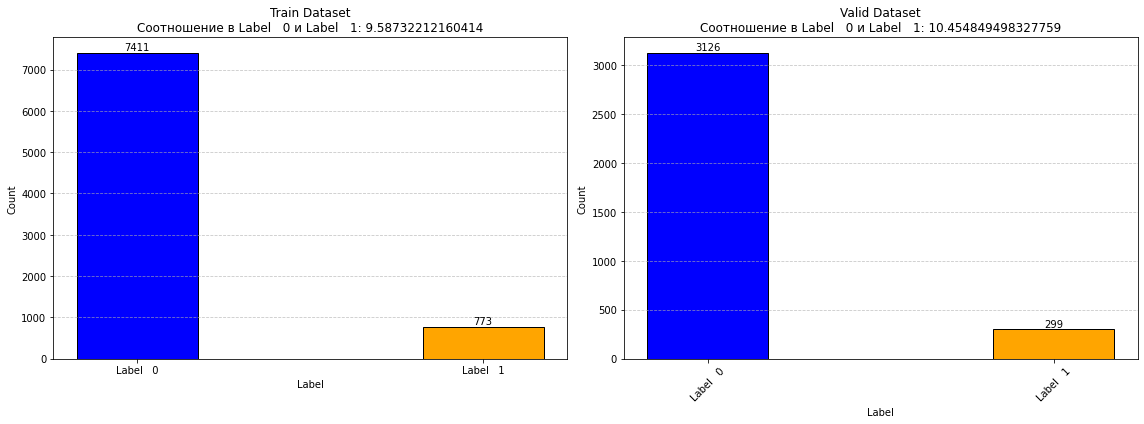

In [270]:
fig, axs = plt.subplots(1,  2, figsize=(16,  6))

datasets = [train_data, valid_data]
titles = ['Train Dataset', 'Valid Dataset']

for i, data in enumerate(datasets):
    label_counts = data['label'].value_counts()
    ratio = label_counts[0] / label_counts[1]
    positions = ['Label   0', 'Label   1']
    counts = [label_counts[0], label_counts[1]]
    bar_width =  0.35

    ax = axs[i]
    rects = ax.bar(positions, counts, width=bar_width, color=['blue', 'orange'], edgecolor='black')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() /  2, height, str(height), ha='center', va='bottom')

    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.set_title(f'{titles[i]}\nСоотношение в Label   0 и Label   1: {ratio}')

    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [271]:
label_counts = train_data['label'].value_counts()

trace = go.Bar(
    x=['Label  0', 'Label  1'],
    y=[label_counts[0], label_counts[1]],
    text=[label_counts[0], label_counts[1]],
    marker=dict(
        color=['rgb(58,  71,  80)', 'rgb(255,  87,  51)']
    ),
    orientation='v'
)

layout = go.Layout(
    title='Distribution of Labels',
    xaxis=dict(
        title='Label'
    ),
    yaxis=dict(
        title='Count'
    )
)

data = [trace]

init_notebook_mode(connected=True)
iplot({'data': data, 'layout': layout})


В данных видим, то у нас один класс практически в 10 раз больше другого. Это может привести к недообучению модели, поэтому выборку неплохо было бы сбалансировать. Применим метод апсемлинга. Введем коэффициент (rat), который указывает, во сколько раз количество записей в классе с меткой 0 больше, чем количество записей в классе с меткой 1. Далее повторяем наименьший наименьший класс ровно rat раз, добавляем к датасету, смешиваем и приводим впорядок индексы.

In [272]:
rat = len(train_data.loc[train_data['label']==0]) // len(train_data.loc[train_data['label']==1])

df_1 = train_data.loc[train_data['label']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]

train_data = pd.concat([train_data.loc[train_data['label']==0], df_1]).sample(frac=1)

train_data.reset_index(drop=True, inplace=True)

print(train_data['label'].value_counts())


0    7411
1    6957
Name: label, dtype: int64


## Токенизация, лемматизация, накидывание признаков

Далее займёмся featureendineering. Поделим твиты на токены, лематизируем, оставим основы, подсчитаем количество частей речи. Также заюзаем W2V.

In [273]:
train_data = train_data.drop('tweet_id', axis=1)
test_data = test_data.drop('tweet_id', axis=1)
valid_data = valid_data.drop('tweet_id', axis=1)

In [274]:
def clean_lemmatize_token(tweet):
    
    '''Предобработка текста, удаление пунктуации, все символы к нижнему регистру, лемматизация слов'''

    cleaned = tweet.translate(str.maketrans('', '', string.punctuation)).lower()

    tokenized = word_tokenize(cleaned)

    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]

    lemmatized_text = ' '.join(lemmatized)
    return lemmatized_text

train_data['tweet'] = train_data['tweet'].apply(clean_lemmatize_token)
test_data['tweet'] = test_data['tweet'].apply(clean_lemmatize_token)
valid_data['tweet'] = valid_data['tweet'].apply(clean_lemmatize_token)

def lemmatize_tweet(tweet):
    
    '''Лемматизация текста на русском языке'''
    
    tokens = tweet.split()

    lemmatized_tokens = [simplemma.lemmatize(token, 'ru') for token in tokens]

    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

train_data['lemmatized'] = train_data['tweet'].apply(lemmatize_tweet)
test_data['lemmatized'] = test_data['tweet'].apply(lemmatize_tweet)
valid_data['lemmatized'] = valid_data['tweet'].apply(lemmatize_tweet)

def count_lemmas(lemmatized_text):
    
    '''Подсчёт лемм'''
    
    words = lemmatized_text.split()
    return len(words)

def count_pos_tags(lemmatized_text, pos_tags):
    
    '''Подсчёт количества слов с заданными частями речи в тексте'''
    
    tagged_words = pos_tag(word_tokenize(lemmatized_text))
    return sum(1 for word, tag in tagged_words if tag in pos_tags)

noun_pos_tags = ['NN', 'NNS', 'NNP', 'NNPS']
verb_pos_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
adjective_pos_tags = ['JJ', 'JJR', 'JJS']

lemmatizer = WordNetLemmatizer()

def count_unique_lemmas(text):
    
    '''Подсчёт уникальных лемм в тексте'''
    
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    unique_lemmas_count = len(Counter(lemmas))
    return unique_lemmas_count

porter_stemmer = PorterStemmer()

def porter_stem_tweet(tweet):
    
    '''Стеминг текста'''
    
    tokens = tweet.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    stemmed_text = ' '.join(stemmed_tokens)
    return stemmed_text

def text_to_embedding(text):
    
    '''Преобразование текста в вектора'''
    
    words = text.split()
    embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

In [275]:
train_data = train_data.drop('tweet', axis=1)
test_data = test_data.drop('tweet', axis=1)
valid_data = valid_data.drop('tweet', axis=1)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [276]:
lemmatized_tweets = train_data['lemmatized'].apply(lambda x: x.split())

In [277]:
train_data['num_lemmas'] = train_data['lemmatized'].apply(count_lemmas)
test_data['num_lemmas'] = test_data['lemmatized'].apply(count_lemmas)

train_data['num_nouns'] = train_data['lemmatized'].apply(lambda x: count_pos_tags(x, noun_pos_tags))
train_data['num_verbs'] = train_data['lemmatized'].apply(lambda x: count_pos_tags(x, verb_pos_tags))
train_data['num_adjectives'] = train_data['lemmatized'].apply(lambda x: count_pos_tags(x, adjective_pos_tags))

test_data['num_nouns'] = test_data['lemmatized'].apply(lambda x: count_pos_tags(x, noun_pos_tags))
test_data['num_verbs'] = test_data['lemmatized'].apply(lambda x: count_pos_tags(x, verb_pos_tags))
test_data['num_adjectives'] = test_data['lemmatized'].apply(lambda x: count_pos_tags(x, adjective_pos_tags))

valid_data['num_lemmas'] = valid_data['lemmatized'].apply(count_lemmas)

valid_data['num_nouns'] = valid_data['lemmatized'].apply(lambda x: count_pos_tags(x, noun_pos_tags))
valid_data['num_verbs'] = valid_data['lemmatized'].apply(lambda x: count_pos_tags(x, verb_pos_tags))
valid_data['num_adjectives'] = valid_data['lemmatized'].apply(lambda x: count_pos_tags(x, adjective_pos_tags))

train_data['num_pronouns'] = train_data['lemmatized'].apply(lambda x: count_pos_tags(x, ['PRON']))
test_data['num_pronouns'] = test_data['lemmatized'].apply(lambda x: count_pos_tags(x, ['PRON']))
valid_data['num_pronouns'] = valid_data['lemmatized'].apply(lambda x: count_pos_tags(x, ['PRON']))

train_data['num_adverbs'] = train_data['lemmatized'].apply(lambda x: count_pos_tags(x, ['ADV']))
test_data['num_adverbs'] = test_data['lemmatized'].apply(lambda x: count_pos_tags(x, ['ADV']))
valid_data['num_adverbs'] = valid_data['lemmatized'].apply(lambda x: count_pos_tags(x, ['ADV']))

train_data['num_prepositions'] = train_data['lemmatized'].apply(lambda x: count_pos_tags(x, ['ADP']))
test_data['num_prepositions'] = test_data['lemmatized'].apply(lambda x: count_pos_tags(x, ['ADP']))
valid_data['num_prepositions'] = valid_data['lemmatized'].apply(lambda x: count_pos_tags(x, ['ADP']))

train_data['num_unique_lemmas'] = train_data['lemmatized'].apply(count_unique_lemmas)
test_data['num_unique_lemmas'] = test_data['lemmatized'].apply(count_unique_lemmas)
valid_data['num_unique_lemmas'] = valid_data['lemmatized'].apply(count_unique_lemmas)

train_data['porter_stemmed'] = train_data['lemmatized'].apply(porter_stem_tweet)
test_data['porter_stemmed'] = test_data['lemmatized'].apply(porter_stem_tweet)
valid_data['porter_stemmed'] = valid_data['lemmatized'].apply(porter_stem_tweet)

In [278]:
train_data = train_data.drop('lemmatized', axis=1)
test_data = test_data.drop('lemmatized', axis=1)
valid_data = valid_data.drop('lemmatized', axis=1)

train_data.rename(columns={'porter_stemmed': 'lemmatized'}, inplace=True)
test_data.rename(columns={'porter_stemmed': 'lemmatized'}, inplace=True)
valid_data.rename(columns={'porter_stemmed': 'lemmatized'}, inplace=True)

In [279]:
tokenized_tweets = train_data['lemmatized'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4)

In [280]:
X_train_word2vec = np.vstack(X_train['lemmatized'].apply(text_to_embedding))
X_test_word2vec = np.vstack(X_test['lemmatized'].apply(text_to_embedding))
X_valid_word2vec = np.vstack(X_valid['lemmatized'].apply(text_to_embedding))

train_data = pd.concat([train_data, pd.DataFrame(X_train_word2vec)], axis=1) #объединяем вектора с данными в датасете
test_data = pd.concat([test_data, pd.DataFrame(X_test_word2vec)], axis=1)
valid_data = pd.concat([valid_data, pd.DataFrame(X_test_word2vec)], axis=1)

train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)
valid_data.fillna(0, inplace=True)

# Обучение

Теперь переходим к обучению моделей. Текст разбиваем на тренировочную и тестовые выборки.

In [281]:
X = train_data.drop('label', axis=1)
y = train_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [282]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11494, 109)
(2874, 109)
(11494,)
(2874,)


In [283]:
X_train

,num_lemmas,num_nouns,num_verbs,num_adjectives,num_pronouns,num_adverbs,num_prepositions,num_unique_lemmas,lemmatized,0,...,90,91,92,93,94,95,96,97,98,99
8247,18,17,0,1,0,0,0,16,интересный побочка от ламотриджин не мочь слад...,-0.404736,...,0.642771,0.257990,0.078146,0.134421,0.810009,0.478324,0.100386,-0.320472,0.116837,-0.105944
13596,7,6,0,1,0,0,0,7,сальбутамол в голова ударить не рассчитать доза,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3822,21,18,1,1,0,0,0,19,я пачка есть феназепам у меня диагноз но от се...,-0.472271,...,0.800177,0.245626,-0.096916,0.110806,0.989008,0.402261,0.060305,-0.528013,0.058411,-0.086609
13262,13,11,0,1,0,0,0,13,кветиапин почему ты така жестокий еще только 2...,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6086,30,29,0,1,0,0,0,28,кроме тот что высокий доза прозака порождать п...,-0.388932,...,0.848021,0.202059,-0.047772,0.067175,0.991364,0.386252,-0.007799,-0.466347,0.008983,-0.033447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,8,7,0,1,0,0,0,8,да у меня закончиться курс флуоксетина сильный...,-0.586438,...,0.854336,0.318982,-0.090158,0.209664,1.036224,0.572233,0.060834,-0.612618,0.086986,-0.083254
13418,15,12,1,0,0,0,0,15,aalien gtи да я в депрессия венлафаксин 300мгс...,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5390,6,5,0,1,0,0,0,6,присниться шо закинуться ксанаксом в аптека,-0.611085,...,0.969584,0.355296,0.010099,0.198648,1.061168,0.535623,0.120014,-0.511037,0.107483,-0.131283
860,18,17,0,1,0,0,0,17,на совещание рассказать как дитя траванулись б...,-0.528755,...,0.771560,0.295881,0.045702,0.108926,0.932827,0.524666,0.105029,-0.451394,0.043812,-0.158478


In [284]:
y_train

8247     1
13596    0
3822     1
13262    1
6086     1
        ..
5191     0
13418    0
5390     0
860      1
7270     0
Name: label, Length: 11494, dtype: int64

Теперь нужно применить TF-IDF, StandartScaler и BoW отдельно к столбцу с леммами. Для этого воспользуемся трансформером.

In [285]:
custom_stop_words = set(stopwords.words('russian'))
numerical_features = ['num_lemmas', 'num_nouns', 'num_verbs', 'num_adjectives', 'num_unique_lemmas']

transformer = ColumnTransformer(
    transformers=[
        ('lemmatized_tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words=custom_stop_words), 'lemmatized'),
        ('numerical_scaler', StandardScaler(), numerical_features),
        ('bag_of_words', CountVectorizer(max_features=1000, ngram_range=(1, 2), stop_words=custom_stop_words), 'lemmatized')
    ],
    remainder='passthrough' 
)

In [286]:
X_train_encoded = transformer.fit_transform(X_train)
X_test_encoded = transformer.transform(X_test)

c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [287]:
print(X_train_encoded.shape)
print(X_test_encoded.shape)
print(y_train.shape)
print(y_test.shape)

(11494, 2108)
(2874, 2108)
(11494,)
(2874,)


Данные готовы. Можно переходить к моделям.

## Бейзлайн

In [288]:
model = LogisticRegression()
model.fit(X_train_encoded, y_train)
y_pred = model.predict_proba(X_test_encoded)[:,  1]

roc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC Score:', roc_auc)

ROC-AUC Score: 0.9437319605602152


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Логистическая регрессия показала высокую оценку ROC-AUC. Но нам нужно взять более подходящую модель для оценок, так как на тесте все может быть иначе.

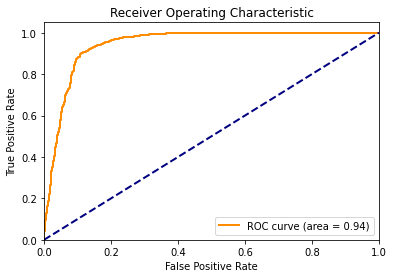

In [289]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,  1], [0,  1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,  1.0])
plt.ylim([0.0,  1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Выбираем модель

Для задачи классификации в NLP хорошо бы подошёл метод опорных векторов, так как он хорошо работает в пространствах высокой размерности, хорошо работает с разреженными матрицами и подходяит для работы с векторами.

Также я еще выбрал LightGBM, потому что он может достигнуть высокой точности классификации ис спосбен моделировать сложные нелинейные зависимости, а нам это и надо.

### Метод опорных векторов

In [290]:
param_grid = {
    'C': [0.1, 0.5, 1, 1.5, 2],
    'penalty': ['l2'],
    'loss': ['squared_hinge'],
    'dual': [True, False],
    'class_weight': [None, 'balanced'],
}

model = LinearSVC(random_state=RANDOM_STATE)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=1, verbose=3)
grid_result_svm = grid_search.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END C=0.1, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.945 total time=   0.8s
[CV 2/3] END C=0.1, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.946 total time=   0.6s
[CV 3/3] END C=0.1, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.943 total time=   0.6s
[CV 1/3] END C=0.1, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.945 total time=   0.5s
[CV 2/3] END C=0.1, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.946 total time=   0.4s
[CV 3/3] END C=0.1, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.943 total time=   0.5s
[CV 1/3] END C=0.1, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.945 total time=   0.6s
[CV 2/3] END C=0.1, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.946 total time=   0.6s
[CV 3/3] END C=0

c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/3] END C=0.5, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.948 total time=   2.8s
[CV 3/3] END C=0.5, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.948 total time=   2.1s
[CV 1/3] END C=0.5, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.948 total time=   0.7s
[CV 2/3] END C=0.5, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.948 total time=   0.7s
[CV 3/3] END C=0.5, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.948 total time=   0.6s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 1/3] END C=0.5, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.948 total time=   3.0s
[CV 2/3] END C=0.5, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.948 total time=   2.5s
[CV 3/3] END C=0.5, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.948 total time=   2.1s
[CV 1/3] END C=0.5, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.948 total time=   0.8s
[CV 2/3] END C=0.5, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.948 total time=   0.8s
[CV 3/3] END C=0.5, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.948 total time=   0.7s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 1/3] END C=1, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.948 total time=   2.7s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/3] END C=1, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.947 total time=   2.4s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 3/3] END C=1, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.947 total time=   2.4s
[CV 1/3] END C=1, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.948 total time=   0.8s
[CV 2/3] END C=1, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.947 total time=   0.8s
[CV 3/3] END C=1, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.947 total time=   0.8s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 1/3] END C=1, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.948 total time=   2.8s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/3] END C=1, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.947 total time=   2.6s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 3/3] END C=1, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.948 total time=   2.8s
[CV 1/3] END C=1, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.948 total time=   0.8s
[CV 2/3] END C=1, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.947 total time=   0.8s
[CV 3/3] END C=1, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.948 total time=   0.8s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 1/3] END C=1.5, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.947 total time=   2.6s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/3] END C=1.5, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.947 total time=   2.5s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 3/3] END C=1.5, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.946 total time=   2.0s
[CV 1/3] END C=1.5, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.947 total time=   0.9s
[CV 2/3] END C=1.5, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.947 total time=   0.9s
[CV 3/3] END C=1.5, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.946 total time=   0.9s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 1/3] END C=1.5, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.947 total time=   2.7s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/3] END C=1.5, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.947 total time=   2.5s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 3/3] END C=1.5, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.946 total time=   2.5s
[CV 1/3] END C=1.5, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.947 total time=   1.3s
[CV 2/3] END C=1.5, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.947 total time=   1.1s
[CV 3/3] END C=1.5, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.946 total time=   1.1s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 1/3] END C=2, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.947 total time=   2.5s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/3] END C=2, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.946 total time=   2.5s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 3/3] END C=2, class_weight=None, dual=True, loss=squared_hinge, penalty=l2;, score=0.945 total time=   2.4s
[CV 1/3] END C=2, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.947 total time=   1.0s
[CV 2/3] END C=2, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.946 total time=   1.2s
[CV 3/3] END C=2, class_weight=None, dual=False, loss=squared_hinge, penalty=l2;, score=0.945 total time=   1.5s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 1/3] END C=2, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.947 total time=   2.5s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/3] END C=2, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.946 total time=   2.7s


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 3/3] END C=2, class_weight=balanced, dual=True, loss=squared_hinge, penalty=l2;, score=0.946 total time=   2.0s
[CV 1/3] END C=2, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.947 total time=   1.2s
[CV 2/3] END C=2, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.946 total time=   1.3s
[CV 3/3] END C=2, class_weight=balanced, dual=False, loss=squared_hinge, penalty=l2;, score=0.946 total time=   1.5s


In [291]:
print("Лучший: %f при %s" % (grid_result_svm.best_score_, grid_result_svm.best_params_))

means = grid_result_svm.cv_results_['mean_test_score']
stds = grid_result_svm.cv_results_['std_test_score']
params = grid_result_svm.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) with: %r" % (mean, std *  2, param))

Лучший: 0.947982 при {'C': 0.5, 'class_weight': 'balanced', 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.945 (+/-0.003) with: {'C': 0.1, 'class_weight': None, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.945 (+/-0.003) with: {'C': 0.1, 'class_weight': None, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.945 (+/-0.003) with: {'C': 0.1, 'class_weight': 'balanced', 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.945 (+/-0.003) with: {'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.948 (+/-0.000) with: {'C': 0.5, 'class_weight': None, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.948 (+/-0.000) with: {'C': 0.5, 'class_weight': None, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.948 (+/-0.000) with: {'C': 0.5, 'class_weight': 'balanced', 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.948 (+/-0.000) with: {'C': 0.5, 'class_weight': 'balanced', 'dual': False, '

In [292]:
best_model_svm = grid_result_svm.best_estimator_
best_model_svm.fit(X_train_encoded, y_train)

test_score = best_model_svm.score(X_test_encoded, y_test)

print("Test ROC-AUC Score: ", test_score)

Test ROC-AUC Score:  0.9095337508698678


In [293]:
X_valid = valid_data.drop('label', axis=1)
y_valid = valid_data['label']
X_valid_encoded = transformer.transform(X_valid)

In [294]:
valid_score = best_model_svm.score(X_valid_encoded, y_valid)
print("Validation ROC-AUC Score: ", valid_score)

Validation ROC-AUC Score:  0.8172262773722627


По оценкам на тестовой выборки SVM хорошо себя показала в плане предсказания. Посмотрим что выдаст LGBMC.

## LightGBM

In [295]:
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_lambda': [0.15, 0.2, 0.25, 0.5, 1],
    'n_estimators': [700, 800, 900]
}

model = LGBMClassifier(random_state=RANDOM_STATE)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=1, verbose=3)

grid_result_cb= grid_search.fit(X_train_encoded, y_train)


Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=700, reg_lambda=0.15;, score=0.859 total time=   6.0s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=700, reg_lambda=0.15;, score=0.866 total time=   6.1s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=700, reg_lambda=0.15;, score=0.863 total time=  10.7s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=700, reg_lambda=0.2;, score=0.860 total time=  13.6s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=700, reg_lambda=0.2;, score=0.866 total time=  10.9s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=700, reg_lambda=0.2;, score=0.863 total time=   6.8s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=700, reg_lambda=0.25;, score=0.858 total time=   6.3s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=700, reg_lambda=0.25;, score=0.864 total time=   6.6s
[CV 3/3] END learning_rate=0.01, max_

In [296]:
print("Лучший: %f при %s" % (grid_result_cb.best_score_, grid_result_cb.best_params_))

means = grid_result_cb.cv_results_['mean_test_score']
stds = grid_result_cb.cv_results_['std_test_score']
params = grid_result_cb.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) with: %r" % (mean, std *  2, param))

Лучший: 0.972616 при {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 900, 'reg_lambda': 0.15}
0.863 (+/-0.006) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700, 'reg_lambda': 0.15}
0.863 (+/-0.005) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700, 'reg_lambda': 0.2}
0.861 (+/-0.005) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700, 'reg_lambda': 0.25}
0.859 (+/-0.007) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700, 'reg_lambda': 0.5}
0.856 (+/-0.006) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700, 'reg_lambda': 1}
0.871 (+/-0.006) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800, 'reg_lambda': 0.15}
0.871 (+/-0.007) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800, 'reg_lambda': 0.2}
0.870 (+/-0.006) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800, 'reg_lambda': 0.25}
0.868 (+/-0.007) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimat

### 

In [297]:
best_model_cb = grid_result_cb.best_estimator_
best_model_cb.fit(X_train_encoded, y_train)

test_score = best_model_cb.score(X_test_encoded, y_test)

print("Test ROC-AUC Score: ", test_score)

Test ROC-AUC Score:  0.9551148225469729


LGBMC Также проявила сепбя очень хорошо. Поэтому две модели могут быть задействованы в предсказании на тесте.

In [298]:
with open('best_model_cb.pkl', 'wb') as file:
    pickle.dump(best_model_cb, file)

In [299]:
with open('best_model_cb.pkl', 'rb') as file:
    best_model_cb = pickle.load(file)

In [300]:
valid_score = best_model_cb.score(X_valid_encoded, y_valid)
print("Validation ROC-AUC Score: ", valid_score)

Validation ROC-AUC Score:  0.8668613138686131


## Тест

In [301]:
test_data_encoded = transformer.transform(test_data)

predictions_svm = best_model_svm.predict(test_data_encoded)

results = pd.concat([test_data_orig, pd.Series(predictions_svm, name='prediction_svm')], axis=1)

results = results.drop(['tweet'], axis=1)
results = results.rename(columns={'prediction_svm': 'label'})
results.to_csv('results.csv', index=False)

Мы получили файл с предсказаниями, которыйц может быть успешно отправлен на сайт. Было решение отправить предсказания SVM. Для того, тчо бы отправить LGBMC модель, нужно поменять модель _svm на _gbm.

In [302]:
##

## BioBert

И в заключении попытка разобраться с нейронками. Я нашел модель, которая может справляться с медицинскими текстами и сделал вот такую простую архитектуру.

In [313]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from transformers import AutoTokenizer

In [314]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [315]:
def preprocess_data(data):
    tokenized_texts = []
    for index, row in data.iterrows():
        text = row['tweet']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        tokenized_texts.append(inputs)
    return tokenized_texts

In [316]:
train_data = pd.read_csv('train.tsv', sep="\t")
test_data = pd.read_csv('test.tsv', sep="\t")
valid_data = pd.read_csv('valid.tsv', sep="\t")

test_texts = preprocess_data(test_data)

In [318]:
model.eval()
predicted_labels = []
with torch.no_grad():
    for inputs in tqdm(test_texts, desc="Predicting labels", ncols=100):
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_label = 1 if probabilities[:, 1].item() > 0.5 else 0
        predicted_labels.append(predicted_label)

'model.eval()\npredicted_labels = []\nwith torch.no_grad():\n    for inputs in tqdm(test_texts, desc="Predicting labels", ncols=100):\n        outputs = model(**inputs)\n        logits = outputs.logits\n        probabilities = torch.softmax(logits, dim=1)\n        predicted_label = 1 if probabilities[:, 1].item() > 0.5 else 0\n        predicted_labels.append(predicted_label)'

In [319]:
test_data['predicted_label'] = predicted_labels
test_data = test_data.drop(['tweet'], axis=1)
test_data = test_data.rename(columns={'predicted_label': 'label'})

"test_data['predicted_label'] = predicted_labels\ntest_data = test_data.drop(['tweet'], axis=1)\ntest_data = test_data.rename(columns={'predicted_label': 'label'})"

In [ ]:
test_data

In [ ]:
test_data.to_csv("predicted_test_labels.csv", index=False)

In [320]:
##